In [141]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import itertools
import mne
from mne.decoding import CSP
from mne import Epochs
from mne.decoding import SPoC
mne.set_log_level(verbose='warning') #to avoid info at terminal
import pickle
import sys
import IO
import os
import time 

import tensorflow as tf
import keras
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout

from tensorflow.python.keras import backend as K
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

from scipy import stats
from collections import OrderedDict
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from bayes_opt import BayesianOptimization
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
import gc
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBRegressor


In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

### get the data

In [3]:
def get_int_runs(subject_id, subfolder):
    """

    :param patient_idx:
    :return: list with all run files for the given patient
    """
    os.listdir(settings['out_path'])

    if 'right' in str(subfolder):
        list_subject = [i for i in os.listdir(settings['out_path']) if i.startswith('sub_'+subject_id+'_sess_right') and i.endswith('.p')]
    else:
        list_subject = [i for i in os.listdir(settings['out_path']) if i.startswith('sub_'+subject_id+'_sess_left') and i.endswith('.p')]

    return list_subject


def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps (with downsample_rate=100) in 100ms / need to check with 1375Hz
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]
#%%

In [4]:
settings = {}
settings['BIDS_path'] = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\"
settings['out_path'] = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\derivatives\\Int_old_grid\\"
settings['out_path_process'] = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\MOVEMENT DATA\\ECoG_STN\XGB_Out_Full\\"
settings['frequencyranges']=[[4, 8], [8, 12], [13, 20], [20, 35], [13, 35], [60, 80], [90, 200], [60, 200]]
settings['seglengths']=[1, 2, 2, 3, 3, 3, 10, 10, 10]
settings['num_patients']=['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']


In [99]:
signal_ = "ECOG"
sub_idx = 1
subject_path=settings['BIDS_path'] + 'sub-' + settings['num_patients'][sub_idx]
subfolder=IO.get_subfolders(subject_path)

X=[]
Y_con=[]
Y_ips=[]
for sess_idx in range(len(subfolder)):
    X=[]
    Y_con=[]
    Y_ips=[]
    list_subject=get_int_runs(settings['num_patients'][sub_idx], subfolder[sess_idx])
    list_subject=sorted(list_subject)
    if signal_=="ECOG":
        if sub_idx==4 and sess_idx==0: #for sake of comparison with spoc
            list_subject.pop(0)
        if sub_idx==4 and sess_idx==1:
            list_subject.pop(2)

    print('RUNNIN SUBJECT_'+ settings['num_patients'][sub_idx]+ '_SESS_'+ str(subfolder[sess_idx]) + '_SIGNAL_' + signal_)

    for run_idx in range(len(list_subject)):
        with open(settings['out_path']+ '/'+ list_subject[run_idx], 'rb') as handle:
            run_ = pickle.load(handle)

        #concatenate features
        #get cortex data only
        if signal_=="ECOG":
            ind_cortex=run_['used_channels']['cortex']
            rf=run_['rf_data_median']
            x=rf[:,ind_cortex,:]
            x=np.clip(x, -2,2) # this should have been implemented in the pipeline
            y=run_['label_baseline_corrected']
            con_true=run_['label_con_true']
            y_con=np.squeeze(y[con_true==True])
            y_ips=np.squeeze(y[con_true==False])
            X.append(x)
            Y_con.append(y_con)
            Y_ips.append(y_ips)
        else:
            ind_subcortex=run_['used_channels']['subcortex']
            if ind_subcortex is not None:

                rf=run_['rf_data_median']
                x=rf[:,ind_subcortex,:]
                x=np.clip(x, -2,2)

                y=run_['label_baseline_corrected']
                con_true=run_['label_con_true']
                y_con=np.squeeze(y[con_true==True])
                y_ips=np.squeeze(y[con_true==False])

                X.append(x)
                Y_con.append(y_con)
                Y_ips.append(y_ips)

    gc.collect() # free unreferenced memory

    X=np.concatenate(X, axis=0)
    Y_con=np.concatenate(Y_con, axis=0)
    Y_ips=np.concatenate(Y_ips, axis=0)
    
    

ses-left
ses-right
RUNNIN SUBJECT_001_SESS_ses-left_SIGNAL_ECOG
RUNNIN SUBJECT_001_SESS_ses-right_SIGNAL_ECOG


In [100]:
X,Y_con = append_time_dim(X[:,0,:], Y_con, time_stamps=5)

In [101]:
X.shape

(10955, 40)

In [102]:
Y_con.shape

(10955,)

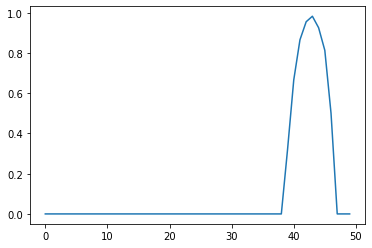

In [240]:
plt.plot(Y_con[250:300])

### model definition

In [103]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### MLP

In [226]:
activation = "relu"
num_dense_layers =5
num_dense_nodes = 10
num_input_nodes = 15

In [227]:
model = Sequential()
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(num_input_nodes, input_shape=(40,), activation=activation))

#create a loop making a new dense layer for the amount passed to this model.
#naming the layers helps avoid tensorflow error deep in the stack trace.
for i in range(num_dense_layers):
    name = 'layer_dense_{0}'.format(i+1)
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(num_dense_nodes,
             activation=activation,
                    name=name
             ))
#add our classification layer.
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1,activation='linear'))

#setup our optimizer and compile
adam = Adam()
model.compile(optimizer=adam, loss='mean_squared_error',
             metrics=[r2_keras])

In [228]:
start = time.time()

X_ch = X

X_train, X_test, y_train, y_test = train_test_split(X_ch, Y_con, train_size=0.7,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=0, shuffle=True)


with tf.device('/cpu:0'):
    
    es = EarlyStopping(monitor='val_r2_keras', mode='max', verbose=1, patience=20)
    mc = ModelCheckpoint('best_model.h5', monitor='val_r2_keras', mode='max', verbose=1, save_best_only=True)
    hist = model.fit(X_train, y_train, epochs=2000, batch_size=100, \
                     validation_data=(X_val, y_val), callbacks=[es,mc]) 
    model = load_model('best_model.h5', custom_objects={'r2_keras': r2_keras})

end = time.time()

Train on 5137 samples, validate on 2531 samples
Epoch 1/2000
5137/5137 [==============================] - 2s 353us/step - loss: 0.9835 - r2_keras: -42.4148 - val_loss: 0.0618 - val_r2_keras: -1.1233

Epoch 00001: val_r2_keras improved from -inf to -1.12333, saving model to best_model.h5
Epoch 2/2000
5137/5137 [==============================] - 1s 104us/step - loss: 0.5359 - r2_keras: -22.0391 - val_loss: 0.0642 - val_r2_keras: -1.2192

Epoch 00002: val_r2_keras did not improve from -1.12333
Epoch 3/2000
5137/5137 [==============================] - 1s 105us/step - loss: 0.3930 - r2_keras: -18.0788 - val_loss: 0.0589 - val_r2_keras: -1.0193

Epoch 00003: val_r2_keras improved from -1.12333 to -1.01926, saving model to best_model.h5
Epoch 4/2000
5137/5137 [==============================] - 1s 107us/step - loss: 0.2925 - r2_keras: -11.2833 - val_loss: 0.0572 - val_r2_keras: -0.9751

Epoch 00004: val_r2_keras improved from -1.01926 to -0.97510, saving model to best_model.h5
Epoch 5/2000
513

5137/5137 [==============================] - 1s 102us/step - loss: 0.0313 - r2_keras: -0.1371 - val_loss: 0.0308 - val_r2_keras: -0.0067

Epoch 00035: val_r2_keras improved from -0.00703 to -0.00670, saving model to best_model.h5
Epoch 36/2000
5137/5137 [==============================] - 1s 101us/step - loss: 0.0314 - r2_keras: -20678.1035 - val_loss: 0.0308 - val_r2_keras: -0.0088

Epoch 00036: val_r2_keras did not improve from -0.00670
Epoch 37/2000
5137/5137 [==============================] - 1s 101us/step - loss: 0.0312 - r2_keras: -0.0344 - val_loss: 0.0308 - val_r2_keras: -0.0069

Epoch 00037: val_r2_keras did not improve from -0.00670
Epoch 38/2000
5137/5137 [==============================] - 1s 100us/step - loss: 0.0311 - r2_keras: -0.0418 - val_loss: 0.0306 - val_r2_keras: -0.0031

Epoch 00038: val_r2_keras improved from -0.00670 to -0.00309, saving model to best_model.h5
Epoch 39/2000
5137/5137 [==============================] - 1s 103us/step - loss: 0.0310 - r2_keras: -0.037

5137/5137 [==============================] - 1s 100us/step - loss: 0.0298 - r2_keras: -45957.7656 - val_loss: 0.0292 - val_r2_keras: 0.0434

Epoch 00071: val_r2_keras improved from 0.03664 to 0.04340, saving model to best_model.h5
Epoch 72/2000
5137/5137 [==============================] - 1s 101us/step - loss: 0.0298 - r2_keras: -58448.7305 - val_loss: 0.0292 - val_r2_keras: 0.0437

Epoch 00072: val_r2_keras improved from 0.04340 to 0.04369, saving model to best_model.h5
Epoch 73/2000
5137/5137 [==============================] - 1s 101us/step - loss: 0.0296 - r2_keras: -78879.7812 - val_loss: 0.0293 - val_r2_keras: 0.0406

Epoch 00073: val_r2_keras did not improve from 0.04369
Epoch 74/2000
5137/5137 [==============================] - 1s 99us/step - loss: 0.0296 - r2_keras: 0.0202 - val_loss: 0.0288 - val_r2_keras: 0.0556

Epoch 00074: val_r2_keras improved from 0.04369 to 0.05561, saving model to best_model.h5
Epoch 75/2000
5137/5137 [==============================] - 1s 102us/step - 

5137/5137 [==============================] - 1s 102us/step - loss: 0.0286 - r2_keras: 0.0356 - val_loss: 0.0270 - val_r2_keras: 0.1145

Epoch 00108: val_r2_keras did not improve from 0.12641
Epoch 109/2000
5137/5137 [==============================] - 1s 103us/step - loss: 0.0282 - r2_keras: -0.1545 - val_loss: 0.0265 - val_r2_keras: 0.1304

Epoch 00109: val_r2_keras improved from 0.12641 to 0.13036, saving model to best_model.h5
Epoch 110/2000
5137/5137 [==============================] - 1s 106us/step - loss: 0.0282 - r2_keras: -0.0032 - val_loss: 0.0261 - val_r2_keras: 0.1389

Epoch 00110: val_r2_keras improved from 0.13036 to 0.13894, saving model to best_model.h5
Epoch 111/2000
5137/5137 [==============================] - 1s 102us/step - loss: 0.0282 - r2_keras: -28807.4727 - val_loss: 0.0263 - val_r2_keras: 0.1348

Epoch 00111: val_r2_keras did not improve from 0.13894
Epoch 112/2000
5137/5137 [==============================] - 1s 101us/step - loss: 0.0281 - r2_keras: 0.0145 - val_

5137/5137 [==============================] - 1s 103us/step - loss: 0.0273 - r2_keras: 0.0143 - val_loss: 0.0251 - val_r2_keras: 0.1709

Epoch 00146: val_r2_keras did not improve from 0.17972
Epoch 147/2000
5137/5137 [==============================] - 1s 101us/step - loss: 0.0265 - r2_keras: 0.0800 - val_loss: 0.0250 - val_r2_keras: 0.1745

Epoch 00147: val_r2_keras did not improve from 0.17972
Epoch 148/2000
5137/5137 [==============================] - 1s 99us/step - loss: 0.0263 - r2_keras: 0.0829 - val_loss: 0.0252 - val_r2_keras: 0.1669

Epoch 00148: val_r2_keras did not improve from 0.17972
Epoch 149/2000
5137/5137 [==============================] - 1s 101us/step - loss: 0.0268 - r2_keras: 0.0934 - val_loss: 0.0250 - val_r2_keras: 0.1749

Epoch 00149: val_r2_keras did not improve from 0.17972
Epoch 150/2000
5137/5137 [==============================] - 1s 99us/step - loss: 0.0264 - r2_keras: -41320.5820 - val_loss: 0.0255 - val_r2_keras: 0.1627

Epoch 00150: val_r2_keras did not imp

In [229]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_135 (Bat (None, 40)                160       
_________________________________________________________________
dropout_81 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 15)                615       
_________________________________________________________________
batch_normalization_136 (Bat (None, 15)                60        
_________________________________________________________________
dropout_82 (Dropout)         (None, 15)                0         
_________________________________________________________________
layer_dense_1 (Dense)        (None, 10)                160       
_________________________________________________________________
batch_normalization_137 (Bat (None, 10)              

In [231]:
end - start

93.48684811592102

In [232]:
((end - start)*3*3* 60 *20)/ (3600*24)

11.685856014490128

In [233]:
with tf.device('/cpu:0'):
    print(metrics.r2_score(y_train, model.predict(X_train)[:,0]))

0.20290005767229302


In [234]:
with tf.device('/cpu:0'):
    print(metrics.r2_score(y_test, model.predict(X_test)[:,0]))

0.19771520360910022


In [235]:
hist.history.keys()

dict_keys(['val_loss', 'val_r2_keras', 'loss', 'r2_keras'])

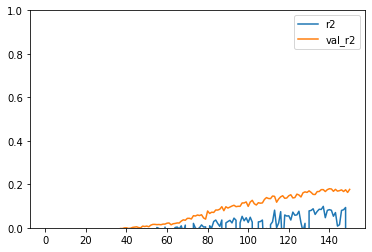

In [236]:
plt.plot(hist.history["r2_keras"], label="r2")
plt.plot(hist.history["val_r2_keras"], label="val_r2")
plt.ylim(0, 1)
plt.legend()

### CNN

In [160]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (8,5,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(units = 50 , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'linear'))
    adam = Adam()
    #sgd = SGD()
    model.compile(optimizer=adam, loss='mean_squared_error',
             metrics=[r2_keras])
    return model

In [161]:
X_ch.shape

(10955, 40)

In [162]:
X_ch_ = np.reshape(X_ch, (X_ch.shape[0], 8, 5), "F")
X_ch_ = X_ch_.reshape(-1, 8, 5, 1)

In [190]:
start = time.time()

X_train, X_test, y_train, y_test = train_test_split(X_ch_, Y_con, train_size=0.7,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True)


with tf.device('/gpu:0'):
    
    es = EarlyStopping(monitor='val_r2_keras', mode='max', verbose=1, patience=15)
    mc = ModelCheckpoint('best_model.h5', monitor='val_r2_keras', mode='max', verbose=1, save_best_only=True)
    
    model = define_model()
    
    hist = model.fit(X_train, y_train, epochs=2000, batch_size=100, \
                     validation_data=(X_val, y_val), callbacks=[es,mc]) 
    
    model = load_model('best_model.h5', custom_objects={'r2_keras': r2_keras})

end = time.time()

Train on 5367 samples, validate on 2301 samples
Epoch 1/2000
5367/5367 [==============================] - 2s 418us/step - loss: 0.7630 - r2_keras: -27.8963 - val_loss: 0.1590 - val_r2_keras: -71111.8203

Epoch 00001: val_r2_keras improved from -inf to -71111.82031, saving model to best_model.h5
Epoch 2/2000
5367/5367 [==============================] - 1s 152us/step - loss: 0.3791 - r2_keras: -13.1630 - val_loss: 0.2259 - val_r2_keras: -107035.3359

Epoch 00002: val_r2_keras did not improve from -71111.82031
Epoch 3/2000
5367/5367 [==============================] - 1s 154us/step - loss: 0.3042 - r2_keras: -10.9781 - val_loss: 0.1508 - val_r2_keras: -76998.3438

Epoch 00003: val_r2_keras did not improve from -71111.82031
Epoch 4/2000
5367/5367 [==============================] - 1s 154us/step - loss: 0.2377 - r2_keras: -8.3800 - val_loss: 0.1181 - val_r2_keras: -71161.7891

Epoch 00004: val_r2_keras did not improve from -71111.82031
Epoch 5/2000
5367/5367 [==============================] 

5367/5367 [==============================] - 1s 153us/step - loss: 0.0100 - r2_keras: 0.6326 - val_loss: 0.0255 - val_r2_keras: -3.6341

Epoch 00038: val_r2_keras did not improve from -0.52803
Epoch 39/2000
5367/5367 [==============================] - 1s 154us/step - loss: 0.0088 - r2_keras: 0.5023 - val_loss: 0.0253 - val_r2_keras: -17.4260

Epoch 00039: val_r2_keras did not improve from -0.52803
Epoch 40/2000
5367/5367 [==============================] - 1s 154us/step - loss: 0.0087 - r2_keras: 0.5885 - val_loss: 0.0246 - val_r2_keras: -0.9074

Epoch 00040: val_r2_keras did not improve from -0.52803
Epoch 41/2000
5367/5367 [==============================] - 1s 154us/step - loss: 0.0084 - r2_keras: 0.6411 - val_loss: 0.0266 - val_r2_keras: -118.3214

Epoch 00041: val_r2_keras did not improve from -0.52803
Epoch 42/2000
5367/5367 [==============================] - 1s 152us/step - loss: 0.0080 - r2_keras: 0.6007 - val_loss: 0.0290 - val_r2_keras: -52.2875

Epoch 00042: val_r2_keras did n

In [191]:
with tf.device('/cpu:0'):
    print(metrics.r2_score(y_train, model.predict(X_train)[:,0]))

0.712884076981936


In [192]:
with tf.device('/cpu:0'):
    print(metrics.r2_score(y_test, model.predict(X_test)[:,0]))

0.1448763725670008


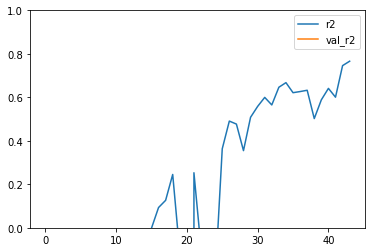

In [193]:
plt.plot(hist.history["r2_keras"], label="r2")
plt.plot(hist.history["val_r2_keras"], label="val_r2")
plt.ylim(0, 1)
plt.legend()

In [196]:
end-start

45.00158977508545

In [197]:
((end - start)*3*3* 200)/ (3600*24)

0.9375331203142802

In [198]:
model = define_model()

In [199]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 8, 5, 32)          320       
_________________________________________________________________
batch_normalization_100 (Bat (None, 8, 5, 32)          128       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 4, 3, 32)          0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 4, 3, 64)          18496     
_________________________________________________________________
batch_normalization_101 (Bat (None, 4, 3, 64)          256       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 2, 2, 64)        